In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, precision_score, recall_score, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

### Cleaning the data

In [40]:
df = pd.read_csv('cs-training.csv')
df = df.rename(columns={'SeriousDlqin2yrs': 'label'})
df = df.dropna()
df = df.drop(columns=['Unnamed: 0'])

print(len(df))
print(df.head(5))

120269
   label  RevolvingUtilizationOfUnsecuredLines  age  \
0      1                              0.766127   45   
1      0                              0.957151   40   
2      0                              0.658180   38   
3      0                              0.233810   30   
4      0                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                                     2   0.802982         9120.0   
1                                     0   0.121876         2600.0   
2                                     1   0.085113         3042.0   
3                                     0   0.036050         3300.0   
4                                     1   0.024926        63588.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                               13                        0   
1                                4                        0   
2                                2                        

### Define training, val and test datasets and visualize data

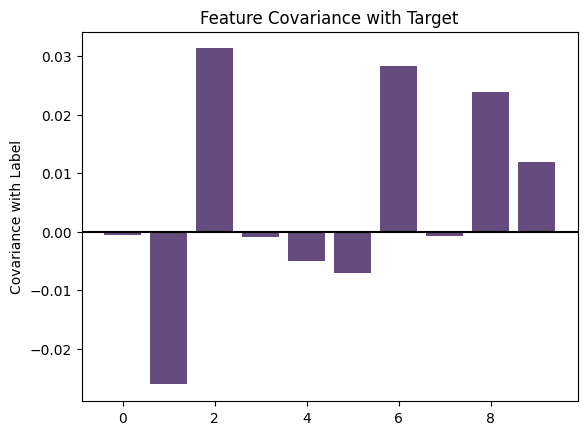

In [50]:
features_count = len(df.columns) - 1
X = df.drop(columns=['label'], axis=1).to_numpy()
y = df['label']

X_train, X_valtest, y_train, y_valtest = train_test_split(X, y, test_size=0.30, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_valtest, y_valtest, test_size=0.50, random_state=1)

X_scaled = StandardScaler().fit_transform(X)

covs = []
for i in range(features_count):
    cov = np.cov(X_scaled[:, i], y)
    covs.append(cov[0, 1])

feature_names = df.drop(columns=['label']).columns.tolist()

plt.bar(range(features_count), covs, color="#654c7e")
plt.axhline(0, color='black')
plt.ylabel('Covariance with Label')
plt.title('Feature Covariance with Target')
plt.show()





### Logistic Regression

              precision    recall  f1-score   support

           0       0.97      0.84      0.90     16830
           1       0.21      0.62      0.32      1210

    accuracy                           0.82     18040
   macro avg       0.59      0.73      0.61     18040
weighted avg       0.92      0.82      0.86     18040



C:\Users\danit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


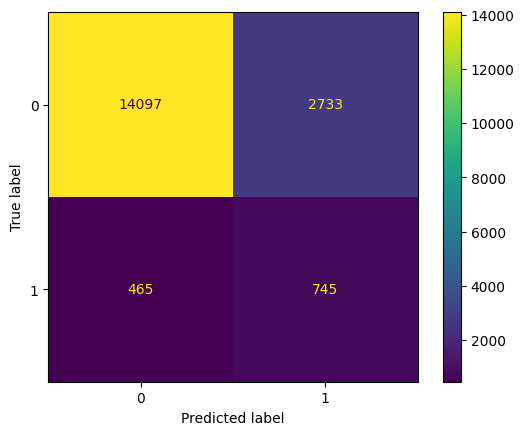

In [25]:
# Train logistic regression model

log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=1)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_val)

print(classification_report(y_val, y_pred))


cm = confusion_matrix(y_val, y_pred)
ConfusionMatrixDisplay(cm, display_labels=log_reg.classes_).plot()

### Random forest

In [ ]:
# Train rnadom forest
base_rf = RandomForestClassifier(class_weight = 'balanced', n_estimators=300, max_depth=10, max_features='sqrt', min_samples_leaf=2, random_state=1)
param_grid = {'class_weight': ['balanced', {0:1, 1:2}, {0:1, 1:3}, {0:1, 1:5}, {0:1, 1:8}, {0:1, 1:10}], 'max_depth': [10, 20, None], 'min_samples_leaf': [1, 2, 4]}
f1_scorer = make_scorer(f1_score)
grid = GridSearchCV(estimator=base_rf, param_grid=param_grid, scoring=f1_scorer, cv=3, verbose=2, n_jobs=-1)
grid.fit(X_train, y_train)

print("\nBest parameters found:")
print(grid.best_params_)
print(f"Best mean F1 score (CV): {grid.best_score_:.2f}")

best_rf = grid.best_estimator_
y_val_pred = best_rf.predict(X_val)

print(f"\nAccuracy score for validation set: {accuracy_score(y_val, y_val_pred):.2f}")
print(f"Precision score for validation set: {precision_score(y_val, y_val_pred):.2f}")
print(f"Recall score for validation set: {recall_score(y_val, y_val_pred):.2f}")
print(f"F1 score for validation set: {f1_score(y_val, y_val_pred):.2f}")
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

final_rf = RandomForestClassifier(n_estimators=800, max_features='sqrt', class_weight=grid.best_params_['class_weight'], max_depth=grid.best_params_['max_depth'], min_samples_leaf=grid.best_params_['min_samples_leaf'], random_state=1)
X_trainval = np.concatenate((X_train, X_val))
y_ftrainval = np.concatenate((y_train, y_val))
final_rf.fit(X_trainval, y_ftrainval)
y_test_pred = final_rf.predict(X_test)


NameError: name 'df' is not defined

In [ ]:
print(f"Accuracy score for test set: {accuracy_score(y_test, y_test_pred):.2f}")
print(f"Precision score for test set: {precision_score(y_test, y_test_pred):.2f}")
print(f"Recall score for test set: {recall_score(y_test, y_test_pred):.2f}")
print(f"F1 score for test set: {f1_score(y_test, y_test_pred):.2f}")
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))